### 1. What is the purpose of this experiment?
Target Encodingによるスコアの向上を見る
### 2. Why do you this?
多様な特徴を作る
### 3. Where are the points of technology and techniques?
Target Encoding
### 4. How do you validate the effectiveness?
CV LB
### 5. What will you do next?
Word Mover Distance

In [1]:
%load_ext autoreload
%autoreload 2
feat_no = 102
is_tfidf = True
is_svd = True
from main_quara import quara_load_data, cleansing_text
from tqdm import tqdm
import numpy as np
import pandas as pd
import time
import datetime
import sys
import re
import gc
import glob
import pickle as pkl
import os
HOME = os.path.expanduser('~')
sys.path.append(f"{HOME}/kaggle/data_analysis/library/")
import utils
from utils import logger_func, get_categorical_features, get_numeric_features, pararell_process
logger = logger_func()

from joblib import Parallel, delayed
from contextlib import contextmanager
@contextmanager
def timer(name):
    """
    Taken from Konstantin Lopuhin https://www.kaggle.com/lopuhin
    in script named : Mercari Golf: 0.3875 CV in 75 LOC, 1900 s
    https://www.kaggle.com/lopuhin/mercari-golf-0-3875-cv-in-75-loc-1900-s
    """
    t0 = time.time()
    yield
    print(f'[{name}] done in {time.time() - t0:.0f} s')
    
from multiprocessing import Pool
import multiprocessing
def pararell_process(func, arg_list, cpu_cnt=multiprocessing.cpu_count()):
    process = Pool(cpu_cnt)
    callback = process.map_async(func, arg_list).get(600)
    process.close()
    process.terminate()
    return callback

# NLP
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

key = 'qid'
qt = 'question_text'
target = 'target'

2018-11-24 16:19:16,252 utils 366 [INFO]    [logger_func] start 


In [2]:
train, test = quara_load_data()
raw_trn_idx = list(train.index)
raw_test_idx = list(test.index)
# del train, test
# gc.collect()

100%|██████████| 3/3 [00:00<00:00, 89.90it/s]


In [7]:
from itertools import chain

# def target_encoding(df):
df = train
word_list = list(chain.from_iterable([doc.split() for doc in df[qt].values]))

df_cnt = pd.DataFrame({'word':word_list}).groupby('word').size().reset_index().rename(columns={0:'cnt'})
# 10回以上出現している単語
df_cnt = df_cnt.query(f"cnt>=10")
print(df_cnt.shape)
display(df_cnt.head(10))

word_list = df_cnt['word'].values

(52761, 2)


,word,cnt
3,!,23
9,"""",527
145,"""2",11
237,"""?",91
248,"""A",221
249,"""A""",17
446,"""All",41
492,"""America",25
499,"""American",33
520,"""An",22


In [ ]:
word_te_dict = {}

# これ全単語でやるのは無理だな
def parallel_get_te(word):
    insincere_ratio = 0
    doc_cnt = 0
    for args in enumerate(df['question_text'].values):
        i  = args[0]
        doc = args[1]
        if doc.count(word):
            insincere_ratio += df[target].values[i]
            doc_cnt += 1
    insincere_ratio /= doc_cnt
    word_te_dict[word] = insincere_ratio
    return word_te_dict
        
with timer("Word Target Encoding"):
    p_list = Parallel(n_jobs=-1)([delayed(parallel_get_te)(word) for word in word_list])
print(p_list[:20])

In [156]:
# from collections import defaultdict
# Load id Text List
train_id_list = list(train[key].values)
test_id_list = list(test[key].values)

train_text_list = list(train[qt].values)
test_text_list = list(test[qt].values)

id_list = train_id_list + test_id_list
text_list = train_text_list + test_text_list
y = train[target]

del train, test
gc.collect()

# for args in zip(id_list, tqdm(text_list)):
def pararell_id_word(args):
    uid = args[0]
    doc = args[1]
    tmp_dict = defaultdict(list)
    for word in doc.split():
        if word in word_list:
            tmp_dict[uid].append(word)
    if uid not in tmp_dict:
        tmp_dict[uid] = []
    return tmp_dict

p_list = Parallel(n_jobs=-1)([delayed(pararell_id_word)(args) for args in zip(id_list, text_list)])

id_word_dict = {}
[id_word_dict.update({list(p.keys())[0]:" ".join(list(p.values())[0])}) for p in p_list if p != 0]
print(len(id_word_dict))

SystemExit: 

TFIDFのsparse_csr_matrixをLGBMに入力する前に、結果として得られるfeature_importanceにおいてどの単語のGainが大きかった見れるようにしておく必要がある。
しかし、50,000カラムのsparse_csr_matrixをtoarrayするとそれだけでallocate_memoryとなる。
よって、まずはmatrixのインデックスに対応する各単語をvectorizer.vocabrary_ or vectorizer.get_feature_names()で取得する。
その後、LGBMのfeature_importance()がカラム順で出力されるのを確認した上で、対応づける。
なお、50,000カラムではLGBMの学習の時間がかかりすぎるので、5,000~10,000カラムに分割し、それぞれLGBMにかけて単語を選別していく。

In [174]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
seed = 1208


class SklearnWrapper(object):
    def __init__(self, clf, seed=0, params=None, seed_bool = True):
        if(seed_bool == True):
            params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    
def get_oof(clf, x_train, y, x_test):
    oof_train = np.zeros((len(raw_train_idx),))
    oof_test = np.zeros((len(raw_test_idx),))
    oof_test_skf = np.empty((5, len(raw_test_idx)))

    fold = 2
    ' KFold '
    folds = StratifiedKFold(n_splits=fold, shuffle=True, random_state=seed)  # 1
    base_train = pd.DataFrame({'index':raw_train_idx})
    kfold = folds.split(base_train, y)

    for i, (train_index, test_index) in enumerate(kfold):
        x_tr = x_train[train_index]
        y_tr = y[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)
        y_pred = clf.predict(x_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

ridge_params = {'alpha':30.0, 'fit_intercept':True, 'normalize':False, 'copy_X':True,
                'max_iter':None, 'tol':0.001, 'solver':'auto', 'random_state':seed}

#Ridge oof method from Faron's kernel
ridge = SklearnWrapper(clf=Ridge, seed = seed, params = ridge_params)
ridge_oof_train, ridge_oof_test = get_oof(ridge, csr_tfidf[raw_train_idx], y, csr_tfidf[raw_test_idx])
ridge_oof_train

0.9012691774819092


SystemExit: 

[LGBM Setting] done in 0 s
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.887448
[400]	valid_0's auc: 0.89717
[600]	valid_0's auc: 0.900281
[800]	valid_0's auc: 0.901587
[1000]	valid_0's auc: 0.902618
[1200]	valid_0's auc: 0.903304
[1400]	valid_0's auc: 0.903469
Early stopping, best iteration is:
[1483]	valid_0's auc: 0.903559
[Validation: 0 | LGBM Train] done in 71 s


2018-11-22 19:18:29,877 utils 88 [INFO]    [<module>] Fold No: 0 | accuracy: 0.15368822729258605 
INFO:utils:Fold No: 0 | accuracy: 0.15368822729258605
2018-11-22 19:18:29,878 utils 89 [INFO]    [<module>] Train Shape: (653061, 677) 
INFO:utils:Train Shape: (653061, 677)
2018-11-22 19:18:29,972 utils 93 [INFO]    [<module>] F1 score at threshold 0.1 is 0.4391473724926784 
INFO:utils:F1 score at threshold 0.1 is 0.4391473724926784
2018-11-22 19:18:30,065 utils 93 [INFO]    [<module>] F1 score at threshold 0.11 is 0.4623496334524084 
INFO:utils:F1 score at threshold 0.11 is 0.4623496334524084
2018-11-22 19:18:30,157 utils 93 [INFO]    [<module>] F1 score at threshold 0.12 is 0.4738053042315704 
INFO:utils:F1 score at threshold 0.12 is 0.4738053042315704
2018-11-22 19:18:30,248 utils 93 [INFO]    [<module>] F1 score at threshold 0.13 is 0.4870659367595392 
INFO:utils:F1 score at threshold 0.13 is 0.4870659367595392
2018-11-22 19:18:30,340 utils 93 [INFO]    [<module>] F1 score at threshol

[Validation: 0 | Prediction & Get F1 score] done in 10 s
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.889362
[400]	valid_0's auc: 0.898276
[600]	valid_0's auc: 0.901738
[800]	valid_0's auc: 0.903439
[1000]	valid_0's auc: 0.904308
[1200]	valid_0's auc: 0.904942
[1400]	valid_0's auc: 0.90513
[1600]	valid_0's auc: 0.905334
[1800]	valid_0's auc: 0.905396
Early stopping, best iteration is:
[1789]	valid_0's auc: 0.905414
[Validation: 1 | LGBM Train] done in 86 s


2018-11-22 19:20:06,432 utils 88 [INFO]    [<module>] Fold No: 1 | accuracy: 0.1531323603936086 
INFO:utils:Fold No: 1 | accuracy: 0.1531323603936086
2018-11-22 19:20:06,434 utils 89 [INFO]    [<module>] Train Shape: (653061, 677) 
INFO:utils:Train Shape: (653061, 677)
2018-11-22 19:20:06,526 utils 93 [INFO]    [<module>] F1 score at threshold 0.1 is 0.44896255579843947 
INFO:utils:F1 score at threshold 0.1 is 0.44896255579843947
2018-11-22 19:20:06,617 utils 93 [INFO]    [<module>] F1 score at threshold 0.11 is 0.46278242662290897 
INFO:utils:F1 score at threshold 0.11 is 0.46278242662290897
2018-11-22 19:20:06,709 utils 93 [INFO]    [<module>] F1 score at threshold 0.12 is 0.4751911652939991 
INFO:utils:F1 score at threshold 0.12 is 0.4751911652939991
2018-11-22 19:20:06,801 utils 93 [INFO]    [<module>] F1 score at threshold 0.13 is 0.48500431211664474 
INFO:utils:F1 score at threshold 0.13 is 0.48500431211664474
2018-11-22 19:20:06,890 utils 93 [INFO]    [<module>] F1 score at thre

[Validation: 1 | Prediction & Get F1 score] done in 11 s


,feature,0_importance,1_importance,avg_importance
458,people,35443.058798,35338.862383,35390.960591
611,trump,32731.477361,31596.615681,32164.046521
663,women,27641.806129,27767.994430,27704.900279
425,muslims,23292.306484,21780.204910,22536.255697
360,liberals,16786.553867,17583.272237,17184.913052


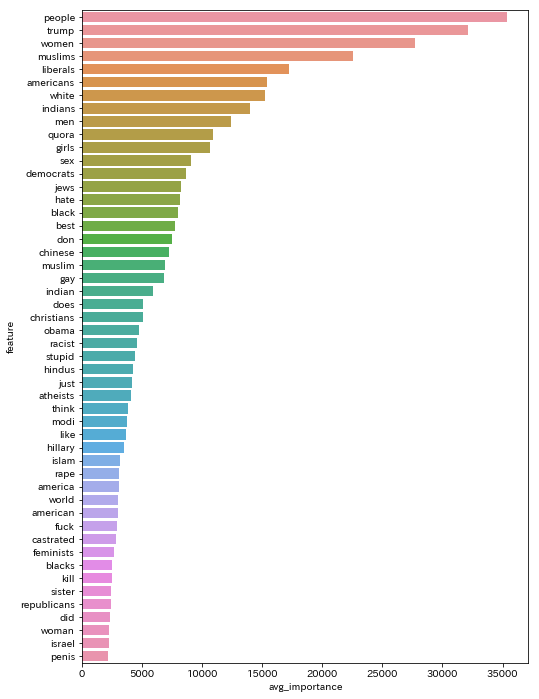

Selece Feature: 673
[Save Feature Importance] done in 0 s
673
['10', '12th', '2017', '2018', 'abortion', 'abuse', 'accept', 'acceptable', 'account', 'act', 'actually', 'admission', 'admit', 'advantages', 'advice', 'affect', 'afraid', 'africa', 'african', 'africans', 'agree', 'air', 'allah', 'allow', 'allowed', 'amazon', 'america', 'american', 'americans', 'android', 'angry', 'answer', 'answers', 'anti', 'app', 'application', 'apply', 'apps', 'arab', 'arabs', 'aren', 'arrogant', 'ashamed', 'asian', 'asians', 'ask', 'asking', 'ass', 'assume', 'atheist', 'atheists', 'attack', 'attacks', 'attracted', 'attractive', 'available', 'aware', 'away', 'bad', 'ban', 'bangalore', 'bank', 'barack', 'beat', 'beautiful', 'behave', 'believe', 'benefits', 'bengali', 'best', 'biased', 'bible', 'big', 'bjp', 'black', 'blacks', 'blame', 'blind', 'book', 'books', 'born', 'boy', 'boys', 'brahmins', 'britain', 'british', 'build', 'business', 'buy', 'called', 'calling', 'came', 'canadians', 'car', 'card', 'care

In [181]:
st_time = time.time()
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import log_loss, confusion_matrix, f1_score, accuracy_score, roc_auc_score
sys.path.append(f'{HOME}/kaggle/data_analysis/model')
from params_lgbm import params_quara
start_time = "{0:%Y%m%d_%H%M%S}".format(datetime.datetime.now())

# Args
feature_list = np.array(tfidf_vectorizer.get_feature_names())
feat_split_size = 4

# LGBM Args
model_type = 'lgb'
fold_type = 'stratified'
metric = 'accuracy'
fold = 2
learning_rate = 0.1
early_stopping_rounds = 100
num_boost_round = 5000
seed = 1208
params = {
    'num_threads': -1,
    'metric': 'auc',
    'objective': 'binary',
    'boosting_type':'gbdt',
    'bagging_freq': 1,
    'sigmoid': 1.1,
    'subsample': 0.9,
    'colsample_bytree': 0.2,
    'lambda_l1': 1,
    'lambda_l2': 5,
    'learning_rate': 0.1,
    'num_leaves': 100,
    'max_depth': 9,
    'bagging_seed': 1208,
    'data_random_seed': 1208,
    'feature_fraction_seed': 1208,
    'random_seed': 1208,
    'verbose': 1
}
# params['device'] = 'gpu'
# params['gpu_platform_id'] = 0
# params['gpu_device_id'] = 0


# Result
select_features = [] # Feature Importanceによって選択したfeature群を入れるリスト

with timer("LGBM Setting"):
    
    prediction = np.array([])
    
    from scipy.sparse import hstack, csr_matrix
    # testも結合されてるので、trainのみにする
#     tmp_train = hstack([csr_tfidf[list(raw_trn_idx)], ridge_oof_train]).toarray()
    tmp_train = csr_tfidf[list(raw_trn_idx)]
    
' KFold '
if fold_type == 'stratified':
    folds = StratifiedKFold(n_splits=fold, shuffle=True, random_state=seed)
    kfold = folds.split(tmp_train, y)

cv_feim = pd.DataFrame() # Feature Importanceの結果ファイルを入れるDF
for n_fold, (trn_idx, val_idx) in enumerate(kfold):
    
    with timer(f"Validation: {n_fold} | LGBM Train"):
        x_train, y_train = tmp_train[trn_idx], y[trn_idx]
        x_val, y_val = tmp_train[val_idx], y[val_idx]
    
        # Dataset
        lgb_train = lgb.Dataset(data=x_train, label=y_train)
        lgb_eval = lgb.Dataset(data=x_val, label=y_val)
        
        estimator = lgb.train(
            train_set=lgb_train,
            valid_sets=lgb_eval,
            params=params,
            verbose_eval=200,
            early_stopping_rounds=early_stopping_rounds,
            num_boost_round=num_boost_round
        )
    
    with timer(f"Validation: {n_fold} | Prediction & Get F1 score"):
        y_pred = estimator.predict(x_val)
        y_pred = (y_pred + ridge_oof_train[val_idx].ravel())/2
        score = log_loss(y_val, y_pred)
        logger.info(f'Fold No: {n_fold} | {metric}: {score}')
        logger.info(f"Train Shape: {x_train.shape}")
        for thresh in np.arange(0.1, 0.301, 0.01):
            thresh = np.round(thresh, 2)
            f1 = f1_score(y_val, (y_pred>thresh).astype(int))
            logger.info(f"F1 score at threshold {thresh} is {f1}")
            
        ' Feature Importance '
        if len(cv_feim):
            cv_feim[f'{n_fold}_importance'] = estimator.feature_importance(importance_type='gain')
        else:
            feim_name = f'{n_fold}_importance'
            feim = pd.Series(estimator.feature_importance(importance_type='gain'), name=feim_name, index=feature_list).to_frame().reset_index().rename(columns={'index':'feature'})
            cv_feim = feim.copy()
            
    
with timer("Save Feature Importance"):
    col_feim = [col for col in cv_feim.columns if col.count('importance')]
    cv_feim['avg_importance'] = cv_feim[col_feim].mean(axis=1)
    cv_feim.sort_values(by='avg_importance', ascending=False, inplace=True)
    from matplotlib import pyplot as plt
    import japanize_matplotlib
    %matplotlib inline
    import seaborn as sns
    plt.figure(figsize=(8, 12))
    display(cv_feim.head())
    sns.barplot(data=cv_feim.iloc[:50, ], x='avg_importance', y='feature')
    plt.show()
    cv_feim.to_csv(f'../valid/{start_time[4:12]}_{model_type}_TFIDF_f1{f1}_auc{score}_lr{learning_rate}.csv', index=False)
    tmp_features = list(cv_feim[cv_feim['avg_importance']>30]['feature'].values)
    print(f'Selece Feature: {len(tmp_features)}')
    select_features += tmp_features
        
select_features = list(set(select_features))
print(len(select_features))
print(sorted(select_features))
print(f'All done in {time.time() - st_time:.0f} s')

Feature Importanceにより絞られたlemma_featureのみのsparse_matrixを作成する.  
ここで出力されたcsr_matrixが、当初の目的だったFeature Importanceにより上位選択されたlemmaのデータセットとなる.

In [76]:
id_list = []
[id_list.append(id)  for word, id in tfidf_vectorizer.vocabulary_.items() if word in select_features]
print(len(id_list))
print(len(select_features))
tmp_train = csr_tfidf.T[id_list].T
tmp_train.shape

1851
1851


(1362492, 1851)

In [73]:
#========================================================================
# Make Train Validation
# Tokenizer
#========================================================================

## some config values 
embed_size = 200 # how big is each word vector
max_features = len(id_list) # how many unique words to use (i.e num rows in embedding vector)
maxlen = len(id_list) # max number of words in a question to use

with timer("Make Train Vaidation Set & Tokenizer"):
    
    ## split to train and val
#     train_X, val_X = train_test_split(train, test_size=0.2, random_state=seed)
#     trn_idx, val_idx = list(train_X.index), list(val_X.index)
    
    train_X, val_X = tmp_train[trn_idx], tmp_train[val_idx]
    ## Get the target values
    train_y = train['target'].values[trn_idx]
    val_y = train['target'].values[val_idx]

[Make Train Vaidation Set & Tokenizer] done in 1 s


In [78]:
import math
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, CuDNNLSTM, Embedding, Dropout, Activation, CuDNNGRU, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
import tensorflow as tf
print(tf.test.is_built_with_cuda())

#========================================================================
# No PreTrain Model
#========================================================================
def no_pretrain_NN():
    with timer("Create No PreTrain Model"):
        inp = Input(shape=(maxlen,))
        x = Embedding(max_features, embed_size)(inp)
#         x = Bidirectional(CuDNNLSTM(64, return_sequences=True))(x)
        x = Bidirectional(LSTM(64, return_sequences=True))(x)
        x = GlobalMaxPool1D()(x)
        x = Dense(16, activation="relu")(x)
        x = Dropout(0.1)(x)
        x = Dense(1, activation="sigmoid")(x)
        model = Model(inputs=inp, outputs=x)
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        
        print(model.summary())
        
    with timer("Model Fitting"):
        ## Train the model 
        model.fit(train_X, train_y, batch_size=512, epochs=2,
                  validation_data=(val_X, val_y)
                 )
        
    with timer("Prediction & Get F1 score"):
        pred_noemb_val_y = model.predict([val_X], batch_size=1024, verbose=1)
        for thresh in np.arange(0.1, 0.501, 0.01):
            thresh = np.round(thresh, 2)
            print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(val_y, (pred_noemb_val_y>thresh).astype(int))))
        del model, inp, x
        import gc; gc.collect()
        time.sleep(10)
with timer(f"Done No PreTrain Model"):
    no_pretrain_NN()

True
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 1851)              0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 1851, 300)         555300    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 1851, 128)         186880    
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout_5 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 17        
Total

InvalidArgumentError: No OpKernel was registered to support Op 'CudnnRNN' with these attrs.  Registered devices: [CPU,XLA_CPU,XLA_GPU], Registered kernels:
  device='GPU'; T in [DT_DOUBLE]
  device='GPU'; T in [DT_FLOAT]
  device='GPU'; T in [DT_HALF]

	 [[node bidirectional_1/CudnnRNN (defined at /home/ubuntu/anaconda3/lib/python3.6/site-packages/tensorflow/contrib/cudnn_rnn/python/ops/cudnn_rnn_ops.py:922)  = CudnnRNN[T=DT_FLOAT, direction="unidirectional", dropout=0, input_mode="linear_input", is_training=true, rnn_mode="lstm", seed=87654321, seed2=0](bidirectional_1/transpose, bidirectional_1/ExpandDims_1, bidirectional_1/ExpandDims_2, bidirectional_1/concat)]]

Caused by op 'bidirectional_1/CudnnRNN', defined at:
  File "/home/ubuntu/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/ubuntu/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-62-b5784077a58a>", line 46, in <module>
    no_pretrain_NN()
  File "<ipython-input-62-b5784077a58a>", line 21, in no_pretrain_NN
    x = Bidirectional(CuDNNLSTM(64, return_sequences=True))(x)
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/layers/wrappers.py", line 427, in __call__
    return super(Bidirectional, self).__call__(inputs, **kwargs)
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/engine/base_layer.py", line 457, in __call__
    output = self.call(inputs, **kwargs)
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/layers/wrappers.py", line 522, in call
    y = self.forward_layer.call(inputs, **kwargs)
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/layers/cudnn_recurrent.py", line 90, in call
    output, states = self._process_batch(inputs, initial_state)
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/layers/cudnn_recurrent.py", line 517, in _process_batch
    is_training=True)
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/tensorflow/contrib/cudnn_rnn/python/ops/cudnn_rnn_ops.py", line 1544, in __call__
    input_data, input_h, input_c, params, is_training=is_training)
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/tensorflow/contrib/cudnn_rnn/python/ops/cudnn_rnn_ops.py", line 1435, in __call__
    seed=self._seed)
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/tensorflow/contrib/cudnn_rnn/python/ops/cudnn_rnn_ops.py", line 922, in _cudnn_rnn
    outputs, output_h, output_c, _ = gen_cudnn_rnn_ops.cudnn_rnn(**args)
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_cudnn_rnn_ops.py", line 116, in cudnn_rnn
    is_training=is_training, name=name)
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3274, in create_op
    op_def=op_def)
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): No OpKernel was registered to support Op 'CudnnRNN' with these attrs.  Registered devices: [CPU,XLA_CPU,XLA_GPU], Registered kernels:
  device='GPU'; T in [DT_DOUBLE]
  device='GPU'; T in [DT_FLOAT]
  device='GPU'; T in [DT_HALF]

	 [[node bidirectional_1/CudnnRNN (defined at /home/ubuntu/anaconda3/lib/python3.6/site-packages/tensorflow/contrib/cudnn_rnn/python/ops/cudnn_rnn_ops.py:922)  = CudnnRNN[T=DT_FLOAT, direction="unidirectional", dropout=0, input_mode="linear_input", is_training=true, rnn_mode="lstm", seed=87654321, seed2=0](bidirectional_1/transpose, bidirectional_1/ExpandDims_1, bidirectional_1/ExpandDims_2, bidirectional_1/concat)]]


In [5]:
#========================================================================
# Glove PreTrain Model
#========================================================================
def glove_pretrain_NN():
    with timer("Get Glove PreTrain Grad"):
        EMBEDDING_FILE = '../input/embeddings/glove.840B.300d/glove.840B.300d.txt'
        def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
        embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))
        
        all_embs = np.stack(embeddings_index.values())
        emb_mean,emb_std = all_embs.mean(), all_embs.std()
        embed_size = all_embs.shape[1]
        
        word_index = tokenizer.word_index
        nb_words = min(max_features, len(word_index))
        embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
        for word, i in word_index.items():
            if i >= max_features: continue
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None: embedding_matrix[i] = embedding_vector
            
    with timer("Create Glove PreTrain Model"):
        inp = Input(shape=(maxlen,))
        x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
        x = Bidirectional(CuDNNGRU(64, return_sequences=True))(x)
        x = GlobalMaxPool1D()(x)
        x = Dense(16, activation="relu")(x)
        x = Dropout(0.1)(x)
        x = Dense(1, activation="sigmoid")(x)
        model = Model(inputs=inp, outputs=x)
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        print(model.summary())
        
    with timer("Model Fitting"):
        model.fit(train_X, train_y, batch_size=512, epochs=2, validation_data=(val_X, val_y))
        
    with timer("Prediction & Get F1 score"):
        pred_glove_val_y = model.predict([val_X], batch_size=1024, verbose=1)
        for thresh in np.arange(0.1, 0.501, 0.01):
            thresh = np.round(thresh, 2)
            print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(val_y, (pred_glove_val_y>thresh).astype(int))))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 300)          9000000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 128)          140544    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total para

In [ ]:
with timer("Make Train Vaidation Set & Tokenizer"):
    
    ## fill up the missing values
    train_X = tmp_train["question_text"].fillna("_na_").values
    
    ## Tokenize the sentences
    tokenizer = Tokenizer(num_words=max_features)
    tokenizer.fit_on_texts(list(train_X))
    train_X = tokenizer.texts_to_sequences(train_X)
    # test_X = tokenizer.texts_to_sequences(test_X)
    
    ## Pad the sentences 
    train_X = pad_sequences(train_X, maxlen=maxlen)
    # test_X = pad_sequences(test_X, maxlen=maxlen)
    
    ## Get the target values
    train_y = train_df['target'].values

    # KFold
    from sklearn.model_selection import StratifiedKFold
    if fold_type == 'stratified':
        folds = StratifiedKFold(n_splits=fold, shuffle=True, random_state=seed)  # 1
        kfold = folds.split(train_X, train_y)

    for n_fold, (trn_idx, val_idx) in enumerate(kfold):
        x_train, x_val = train_X[train_idx], train_X[val_idx]
        y_train, y_val = train_y[train_idx], train_y[val_idx] 